<a href="https://colab.research.google.com/github/caetano-dev/PixFraudDetection/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Context: Financial Transaction Analysis for Money Laundering Detection using Graph Methods

This project involves analyzing large-scale financial transaction data to identify potential money laundering activities. The core approach utilizes graph-based techniques applied to temporal snapshots of transaction networks and in the future will use GNNs.

**Data Used:**
The project processes transaction data from CSV files (e.g., `LI-Large_Trans.csv`, `HI-Small_Trans.csv`). Each transaction record typically includes:
- Timestamp
- From/To Bank and Account identifiers
- Amount sent/received
- Currency sent/received
- Payment Type
- A binary flag indicating if the transaction is part of a known laundering attempt (`is_laundering`).
Additionally, account details (like bank, entity ID, entity name) are loaded from separate files. Known money laundering patterns are also parsed from a text file to identify laundering attempts.
The large dataset is indeed very large, so we need to keep that in mind. Everything is being run on Google Colab, with 10GB of RAM max.

**Preprocessing and Filtering:**
Raw transaction data is preprocessed using **DuckDB** for efficient loading and initial filtering. This involves:
- Reading large CSV files with specified column types (initially all VARCHAR).
- Parsing timestamps into datetime objects.
- Casting numeric fields (amounts) to DOUBLE and boolean flags (`is_laundering`) to INTEGER.
- Applying filters to select transactions based on `payment_type` (primarily 'ACH') and `currency_sent`/`currency_received` (e.g., 'US Dollar'). This filtered data is saved as Parquet files (`1_filtered_normal_transactions.parquet`, `2_filtered_laundering_transactions.parquet`).
- Account data is filtered to include only accounts involved in the selected transactions (`3_filtered_accounts.parquet`).

**Graph Construction:**
For analysis, the filtered transaction data is transformed into a graph representation using the **`graph-tool`**, **`igraph`**, and **`leidenalg`** libraries. This process involves:
- Aggregating transactions within defined **temporal windows** (e.g., 3-day, 7-day windows with a 1-day stride).
- Creating nodes representing financial accounts.
- Creating edges between accounts if a transaction occurred between them within the window.
- Aggregating edge properties: `w_count` (number of transactions), `w_amount` (sum of received amounts in cents), `w_amount_sent` (sum of sent amounts in cents, for directed graphs), and `w_amount_log` (log-scaled received amount, used as a potential edge weight).
- Adding vertex properties: `name` (account ID), `bank_id`, `entity_id`, `entity_name`, and `is_laundering_involved` (indicating if the account participated in a known laundering transaction within the window).
- Vertex-level aggregate properties are also computed: `in_amount_sum`, `out_amount_sum`, `in_deg`, `out_deg`, `in_tx_count`, `out_tx_count`, and `in_out_amount_ratio`.
- Both directed and undirected graphs are constructed depending on the analysis method.

For now, we are developing graph analysis without AI, but in the future, we are going to implement GNNs to find fraudulent accounts.

**Graph Analysis Methods:**
Several graph-based techniques are applied within each time window:
1. **Centrality Baselines:** Standard node centrality measures are computed on the directed graph, including PageRank (weighted by `w_amount_log`), HITS (Hubs and Authorities), in/out degree, total transaction counts, and total amount sums. Custom 'collector' and 'distributor' scores are derived from amount sums.
2. **Personalized PageRank (PPR):** PPR is run on the directed graph using a set of known laundering accounts from an earlier time period (time-based split to avoid look-ahead bias) as seeds. The implementation leverages **`igraph`** for faster computation, optionally using a k-hop subgraph around seeds for speed. The `w_amount_log` can be used as edge weights.
3. **Community Detection:** The Louvain and Leiden algorithms (**`igraph`** and **`leidenalg`**) are applied to the undirected aggregated graph. The **RBConfiguration** variant is used for Leiden, with a tunable `resolution_parameter`. Edge weights (`w_amount_log`) are optionally used.

**Evaluation:**
The performance of different scoring methods (centrality, PPR, community-based) in identifying laundering accounts is evaluated within each time window:
- **Metrics:** Average Precision (AP) and Precision@K (`p_at_0.5pct`, `p_at_1.0pct`, `p_at_2.0pct`) are calculated using `sklearn.metrics`.
- **Attempt Coverage:** For community detection methods, a custom metric (`attcov_at_Kpct`) measures the fraction of known laundering attempts that have at least one involved account present in the top K% of communities ranked by a heuristic score.
- **Heuristic Community Scoring:** Communities are scored based on internal density, average clustering coefficient, and sum of transaction amounts within the community, with a size boost factor.
- **Baselines:** A random baseline is included for comparison, calculating expected performance metrics.
- **Results Storage:** Per-window metrics for all methods are saved to a CSV file (`window_metrics.csv`). A summary of median metrics across all windows is also generated.

**Diagnostics:**
Additional diagnostic steps are performed to understand the nature of the raw data and the impact of filtering:
- Analysis of daily counts and prevalence of normal vs. laundering transactions in the raw data.
- Investigation of payment types and currency combinations present in normal transactions after a specific date cutoff.
- Comparison of transaction counts under strict filtering vs. more relaxed criteria (e.g., including other payment types, or filtering by currency on either leg of the transaction).

**Overall Goal:** The project aims to assess the effectiveness of various graph-based features and community structures in identifying known money laundering activities within dynamic transaction networks across different time periods, providing insights into which methods perform best under different data conditions and compare them to a GNN doing a similar job.


In [ ]:
import os
import re
import duckdb
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
DRIVE_DIR = '/content/drive/MyDrive/AML'

# HI large
#PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/HI_Large')
#TX_CSV = os.path.join(DRIVE_DIR, 'HI-Large_Trans.csv')
#PATTERNS_TXT = os.path.join(DRIVE_DIR, 'HI-Large_Patterns.txt')
#ACCOUNTS_CSV = os.path.join(DRIVE_DIR, 'HI-Large_Accounts.csv')

# HI small
PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/HI_small')
TX_CSV = os.path.join(DRIVE_DIR, 'HI-Small_Trans.csv')
PATTERNS_TXT = os.path.join(DRIVE_DIR, 'HI-Small_Patterns.txt')
ACCOUNTS_CSV = os.path.join(DRIVE_DIR, 'HI-Small_Accounts.csv')

# LI large
# PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/LI_Large')
#TX_CSV = os.path.join(DRIVE_DIR, 'LI-Large_Trans.csv')
#PATTERNS_TXT = os.path.join(DRIVE_DIR, 'LI-Large_Patterns.txt')
#ACCOUNTS_CSV = os.path.join(DRIVE_DIR, 'LI-Large_Accounts.csv')

# LI small
#PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/LI_Small')
#TX_CSV = os.path.join(DRIVE_DIR, 'LI-Small_Trans.csv')
#PATTERNS_TXT = os.path.join(DRIVE_DIR, 'LI-Small_Patterns.txt')
#ACCOUNTS_CSV = os.path.join(DRIVE_DIR, 'LI-Small_Accounts.csv')

os.makedirs(PROCESSED_DIR, exist_ok=True)

if not os.path.exists(TX_CSV):
    raise FileNotFoundError(f"Transaction file not found: {TX_CSV}")
else:
    print(f"Found data folder: {DRIVE_DIR}")
    print("-" * 50)

standard_columns = [
    'timestamp', 'from_bank', 'from_account', 'to_bank', 'to_account',
    'amount_received', 'currency_received', 'amount_sent', 'currency_sent',
    'payment_type', 'is_laundering'
]

column_types = {
    'timestamp': 'VARCHAR',
    'from_bank': 'VARCHAR',
    'from_account': 'VARCHAR',
    'to_bank': 'VARCHAR',
    'to_account': 'VARCHAR',
    'amount_received': 'VARCHAR',
    'currency_received': 'VARCHAR',
    'amount_sent': 'VARCHAR',
    'currency_sent': 'VARCHAR',
    'payment_type': 'VARCHAR',
    'is_laundering': 'VARCHAR'
}

def parse_patterns_file(file_path):
    attempts = []
    current_attempt = None
    attempt_counter = 0

    with open(file_path, 'r') as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            if line.startswith('BEGIN LAUNDERING ATTEMPT'):
                attempt_counter += 1
                m = re.search(r'BEGIN LAUNDERING ATTEMPT\s*-\s*(.+)$', line)
                attempt_type = m.group(1).strip() if m else 'UNKNOWN'
                current_attempt = {
                    'attempt_id': attempt_counter,
                    'attempt_type': attempt_type,
                    'transactions': []
                }
            elif line.startswith('END LAUNDERING ATTEMPT'):
                if current_attempt:
                    attempts.append(current_attempt)
                current_attempt = None
            elif current_attempt:
                parts = [p.strip() for p in line.split(',')]
                if len(parts) >= 11:
                    tx = dict(zip(standard_columns, parts[:11]))
                    tx['attempt_id'] = current_attempt['attempt_id']
                    tx['attempt_type'] = current_attempt['attempt_type']
                    current_attempt['transactions'].append(tx)

    all_transactions = [tx for attempt in attempts for tx in attempt['transactions']]
    return pd.DataFrame(all_transactions, columns=standard_columns + ['attempt_id', 'attempt_type'])

CURRENCIES = [
    "US Dollar",
    "Euro",
    "Yuan",
    "Shekel",
    "Canadian Dollar",
    "UK Pound",
    "Ruble",
    "Australian Dollar",
    "Swiss Franc",
    "Yen",
    "Mexican Peso",
    "Rupee",
    "Brazil Real",
    "Saudi Riyal"
]

con = duckdb.connect(database=':memory:')
con.execute("PRAGMA threads=8")

read_tx_csv_sql = f"""
  SELECT * FROM read_csv_auto(
    '{TX_CSV}',
    delim=',',
    header=false,
    columns={column_types},
    all_varchar=true
  )
"""

ts_parse_sql = """
CASE
  WHEN length(trim(timestamp)) = 16 THEN strptime(trim(timestamp), '%Y/%m/%d %H:%M')
  WHEN length(trim(timestamp)) = 19 THEN strptime(trim(timestamp), '%Y/%m/%d %H:%M:%S')
  ELSE NULL
END
"""

typed_tx_sql = f"""
WITH raw AS ({read_tx_csv_sql})
SELECT
  {ts_parse_sql}::TIMESTAMP AS timestamp,
  trim(from_bank) AS from_bank,
  trim(from_account) AS from_account,
  trim(to_bank) AS to_bank,
  trim(to_account) AS to_account,
  try_cast(nullif(trim(amount_received), '') AS DOUBLE) AS amount_received,
  trim(currency_received) AS currency_received,
  try_cast(nullif(trim(amount_sent), '') AS DOUBLE) AS amount_sent,
  trim(currency_sent) AS currency_sent,
  trim(payment_type) AS payment_type,
  coalesce(try_cast(nullif(trim(is_laundering), '') AS INTEGER), 0) AS is_laundering
FROM raw
WHERE trim(from_account) <> trim(to_account)
"""

def currency_filter_sql(currency_name):
    return f"""
    upper(trim(currency_sent)) = upper('{currency_name}') AND
    upper(trim(currency_received)) = upper('{currency_name}') AND
    upper(trim(payment_type)) = 'ACH'
    """

patterns_df = parse_patterns_file(PATTERNS_TXT)
if patterns_df.empty:
    patterns_df = pd.DataFrame(columns=standard_columns + ['attempt_id', 'attempt_type'])
con.register('patterns_df', patterns_df)

for currency in CURRENCIES:
    cur_dirname = currency.replace(' ', '_')
    OUT_DIR = os.path.join(PROCESSED_DIR, cur_dirname)
    os.makedirs(OUT_DIR, exist_ok=True)

    OUT_STEP1 = os.path.join(OUT_DIR, '1_filtered_normal_transactions.parquet')
    OUT_STEP2 = os.path.join(OUT_DIR, '2_filtered_laundering_transactions.parquet')
    OUT_STEP3 = os.path.join(OUT_DIR, '3_filtered_accounts.parquet')

    filt_sql = currency_filter_sql(currency)

    # Step 1: normal transactions for this currency
    con.execute(f"""
      COPY (
        WITH typed AS ({typed_tx_sql})
        SELECT
          timestamp, from_bank, from_account, to_bank, to_account,
          amount_received, currency_received, amount_sent, currency_sent,
          payment_type, is_laundering
        FROM typed
        WHERE timestamp IS NOT NULL
          AND {filt_sql}
          AND is_laundering = 0
      ) TO '{OUT_STEP1}' (FORMAT PARQUET, COMPRESSION ZSTD)
    """)

    step1_rows = con.execute(f"SELECT COUNT(*) FROM read_parquet('{OUT_STEP1}')").fetchone()[0]
    print(f"[{currency}] Step 1: Saved normal transactions to '{OUT_STEP1}' (rows={step1_rows:,})")

    # Step 2: laundering transactions (from patterns + missing from CSV) for this currency
    con.execute(f"""
      COPY (
        WITH
          pat_raw AS (
            SELECT
              timestamp, from_bank, from_account, to_bank, to_account,
              amount_received, currency_received, amount_sent, currency_sent,
              payment_type, is_laundering,
              attempt_id,
              attempt_type
            FROM patterns_df
          ),
          pat_typed AS (
            SELECT
              {ts_parse_sql}::TIMESTAMP AS timestamp,
              trim(from_bank) AS from_bank,
              trim(from_account) AS from_account,
              trim(to_bank) AS to_bank,
              trim(to_account) AS to_account,
              try_cast(nullif(trim(amount_received), '') AS DOUBLE) AS amount_received,
              trim(currency_received) AS currency_received,
              try_cast(nullif(trim(amount_sent), '') AS DOUBLE) AS amount_sent,
              trim(currency_sent) AS currency_sent,
              trim(payment_type) AS payment_type,
              coalesce(try_cast(nullif(trim(is_laundering), '') AS INTEGER), 0) AS is_laundering,
              try_cast(attempt_id AS BIGINT) AS attempt_id,
              trim(attempt_type) AS attempt_type
            FROM pat_raw
            WHERE trim(from_account) <> trim(to_account)
          ),
          pat_filt AS (
            SELECT
              timestamp, from_bank, from_account, to_bank, to_account,
              amount_received, currency_received, amount_sent, currency_sent,
              payment_type, is_laundering, attempt_id, attempt_type,
              CAST(round(amount_sent * 100) AS BIGINT) AS amount_sent_c,
              CAST(round(amount_received * 100) AS BIGINT) AS amount_received_c
            FROM pat_typed
            WHERE timestamp IS NOT NULL
              AND {filt_sql}
              AND is_laundering = 1
          ),
          raw_pos AS (
            WITH typed AS ({typed_tx_sql})
            SELECT
              timestamp, from_bank, from_account, to_bank, to_account,
              amount_received, currency_received, amount_sent, currency_sent,
              payment_type, is_laundering,
              CAST(round(amount_sent * 100) AS BIGINT) AS amount_sent_c,
              CAST(round(amount_received * 100) AS BIGINT) AS amount_received_c
            FROM typed
            WHERE timestamp IS NOT NULL
              AND {filt_sql}
              AND is_laundering = 1
          ),
          missing AS (
            SELECT raw_pos.*
            FROM raw_pos
            LEFT JOIN pat_filt
              ON raw_pos.timestamp = pat_filt.timestamp
              AND raw_pos.from_bank = pat_filt.from_bank
              AND raw_pos.from_account = pat_filt.from_account
              AND raw_pos.to_bank = pat_filt.to_bank
              AND raw_pos.to_account = pat_filt.to_account
              AND raw_pos.amount_received_c = pat_filt.amount_received_c
              AND raw_pos.amount_sent_c = pat_filt.amount_sent_c
            WHERE pat_filt.timestamp IS NULL
          ),
          unioned AS (
            SELECT
              timestamp, from_bank, from_account, to_bank, to_account,
              amount_received, currency_received, amount_sent, currency_sent,
              payment_type, is_laundering,
              attempt_id, attempt_type
            FROM pat_filt
            UNION ALL
            SELECT
              timestamp, from_bank, from_account, to_bank, to_account,
              amount_received, currency_received, amount_sent, currency_sent,
              payment_type, is_laundering,
              NULL::INTEGER AS attempt_id, 'UNLISTED' AS attempt_type
            FROM missing
          )
        SELECT * FROM unioned
      ) TO '{OUT_STEP2}' (FORMAT PARQUET, COMPRESSION ZSTD)
    """)

    base_count = con.execute("""
      WITH x as (SELECT attempt_type FROM read_parquet(?) WHERE attempt_type <> 'UNLISTED')
      SELECT COUNT(*) FROM x
    """, [OUT_STEP2]).fetchone()[0]
    added_count = con.execute("""
      WITH x as (SELECT attempt_type FROM read_parquet(?) WHERE attempt_type = 'UNLISTED')
      SELECT COUNT(*) FROM x
    """, [OUT_STEP2]).fetchone()[0]
    total_count = con.execute(f"SELECT COUNT(*) FROM read_parquet('{OUT_STEP2}')").fetchone()[0]
    print(f"[{currency}] Step 2: Saved laundering transactions to '{OUT_STEP2}' (patterns={base_count:,}, added_from_csv={added_count:,}, total={total_count:,})")

    # Step 3: Filter accounts involved in either step1 or step2 for this currency
    con.execute(f"""
      COPY (
        WITH all_tx AS (
          SELECT
            timestamp, from_bank, from_account, to_bank, to_account,
            amount_received, currency_received, amount_sent, currency_sent,
            payment_type, is_laundering,
            NULL::INTEGER AS attempt_id, NULL::VARCHAR AS attempt_type
          FROM read_parquet('{OUT_STEP1}')
          UNION ALL
          SELECT
            timestamp, from_bank, from_account, to_bank, to_account,
            amount_received, currency_received, amount_sent, currency_sent,
            payment_type, is_laundering,
            attempt_id, attempt_type
          FROM read_parquet('{OUT_STEP2}')
        ),
        involved AS (
          SELECT DISTINCT from_account AS account FROM all_tx WHERE from_account IS NOT NULL
          UNION
          SELECT DISTINCT to_account AS account FROM all_tx WHERE to_account IS NOT NULL
        ),
        accounts AS (
          SELECT * FROM read_csv_auto(
            '{ACCOUNTS_CSV}',
            delim=',',
            header=false,
            columns={{'bank_name': 'VARCHAR', 'bank_id': 'VARCHAR', 'account_id_hex': 'VARCHAR', 'entity_id': 'VARCHAR', 'entity_name': 'VARCHAR'}},
            all_varchar=true
          )
        )
        SELECT a.*
        FROM accounts a
        INNER JOIN involved i
          ON trim(a.account_id_hex) = trim(i.account)
      ) TO '{OUT_STEP3}' (FORMAT PARQUET, COMPRESSION ZSTD)
    """)

    step3_rows = con.execute(f"SELECT COUNT(*) FROM read_parquet('{OUT_STEP3}')").fetchone()[0]
    print(f"[{currency}] Step 3: Saved filtered account details to '{OUT_STEP3}' (rows={step3_rows:,})")

con.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found data folder: /content/drive/MyDrive/AML
--------------------------------------------------


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[US Dollar] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/US_Dollar/1_filtered_normal_transactions.parquet' (rows=199,869)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[US Dollar] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/US_Dollar/2_filtered_laundering_transactions.parquet' (patterns=1,178, added_from_csv=485, total=1,663)
[US Dollar] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/US_Dollar/3_filtered_accounts.parquet' (rows=93,100)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Euro] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Euro/1_filtered_normal_transactions.parquet' (rows=125,171)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Euro] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Euro/2_filtered_laundering_transactions.parquet' (patterns=883, added_from_csv=320, total=1,203)
[Euro] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Euro/3_filtered_accounts.parquet' (rows=57,219)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Yuan] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Yuan/1_filtered_normal_transactions.parquet' (rows=21,783)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Yuan] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Yuan/2_filtered_laundering_transactions.parquet' (patterns=107, added_from_csv=55, total=162)
[Yuan] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Yuan/3_filtered_accounts.parquet' (rows=10,087)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Shekel] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Shekel/1_filtered_normal_transactions.parquet' (rows=20,365)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Shekel] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Shekel/2_filtered_laundering_transactions.parquet' (patterns=25, added_from_csv=56, total=81)
[Shekel] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Shekel/3_filtered_accounts.parquet' (rows=9,373)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Canadian Dollar] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Canadian_Dollar/1_filtered_normal_transactions.parquet' (rows=15,622)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Canadian Dollar] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Canadian_Dollar/2_filtered_laundering_transactions.parquet' (patterns=76, added_from_csv=37, total=113)
[Canadian Dollar] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Canadian_Dollar/3_filtered_accounts.parquet' (rows=6,937)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[UK Pound] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/UK_Pound/1_filtered_normal_transactions.parquet' (rows=19,087)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[UK Pound] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/UK_Pound/2_filtered_laundering_transactions.parquet' (patterns=71, added_from_csv=35, total=106)
[UK Pound] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/UK_Pound/3_filtered_accounts.parquet' (rows=8,556)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Ruble] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Ruble/1_filtered_normal_transactions.parquet' (rows=16,339)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Ruble] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Ruble/2_filtered_laundering_transactions.parquet' (patterns=72, added_from_csv=43, total=115)
[Ruble] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Ruble/3_filtered_accounts.parquet' (rows=7,407)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Australian Dollar] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Australian_Dollar/1_filtered_normal_transactions.parquet' (rows=14,420)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Australian Dollar] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Australian_Dollar/2_filtered_laundering_transactions.parquet' (patterns=69, added_from_csv=42, total=111)
[Australian Dollar] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Australian_Dollar/3_filtered_accounts.parquet' (rows=6,709)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Swiss Franc] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Swiss_Franc/1_filtered_normal_transactions.parquet' (rows=25,152)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Swiss Franc] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Swiss_Franc/2_filtered_laundering_transactions.parquet' (patterns=114, added_from_csv=50, total=164)
[Swiss Franc] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Swiss_Franc/3_filtered_accounts.parquet' (rows=11,538)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Yen] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Yen/1_filtered_normal_transactions.parquet' (rows=16,460)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Yen] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Yen/2_filtered_laundering_transactions.parquet' (patterns=89, added_from_csv=43, total=132)
[Yen] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Yen/3_filtered_accounts.parquet' (rows=7,693)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Mexican Peso] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Mexican_Peso/1_filtered_normal_transactions.parquet' (rows=11,452)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Mexican Peso] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Mexican_Peso/2_filtered_laundering_transactions.parquet' (patterns=53, added_from_csv=26, total=79)
[Mexican Peso] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Mexican_Peso/3_filtered_accounts.parquet' (rows=5,321)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Rupee] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Rupee/1_filtered_normal_transactions.parquet' (rows=20,738)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Rupee] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Rupee/2_filtered_laundering_transactions.parquet' (patterns=111, added_from_csv=34, total=145)
[Rupee] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Rupee/3_filtered_accounts.parquet' (rows=9,384)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Brazil Real] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Brazil_Real/1_filtered_normal_transactions.parquet' (rows=7,803)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Brazil Real] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Brazil_Real/2_filtered_laundering_transactions.parquet' (patterns=21, added_from_csv=24, total=45)
[Brazil Real] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Brazil_Real/3_filtered_accounts.parquet' (rows=3,411)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Saudi Riyal] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Saudi_Riyal/1_filtered_normal_transactions.parquet' (rows=9,114)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Saudi Riyal] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Saudi_Riyal/2_filtered_laundering_transactions.parquet' (patterns=328, added_from_csv=25, total=353)
[Saudi Riyal] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Saudi_Riyal/3_filtered_accounts.parquet' (rows=4,093)


/tmp/ipython-input-1551590172.py:18: DtypeWarning: Columns (1,3,5,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(TX_CSV, header=None, names=raw_column_names)
/tmp/ipython-input-1551590172.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], errors='coerce')


Daily Transaction Counts and Prevalence (Head):


,normal_count,laundering_count,total_count,normal_prevalence,laundering_prevalence
date,,,,,
2022-09-01,1524497,310,1524807,0.999797,0.000203
2022-09-02,1027408,350,1027758,0.999659,0.000341
2022-09-03,283034,292,283326,0.998969,0.001031
2022-09-04,282185,291,282476,0.998970,0.001030
2022-09-05,657027,370,657397,0.999437,0.000563
2022-09-06,656790,380,657170,0.999422,0.000578
2022-09-07,658136,368,658504,0.999441,0.000559
2022-09-08,657536,402,657938,0.999389,0.000611
2022-09-09,891206,367,891573,0.999588,0.000412


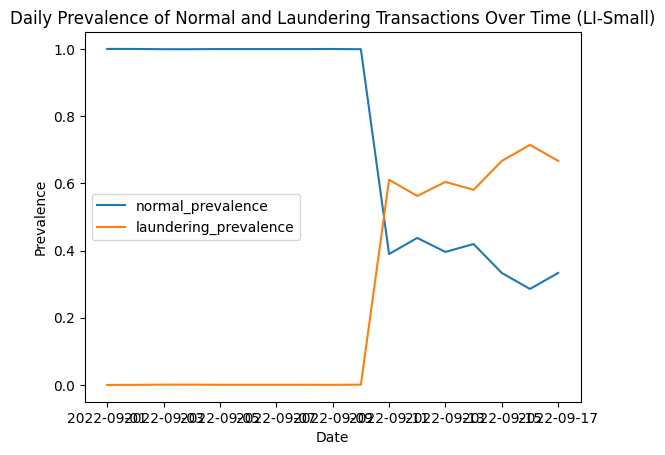

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

DRIVE_DIR = '/content/drive/MyDrive/AML'
TX_CSV = os.path.join(DRIVE_DIR, 'LI-Small_Trans.csv')

raw_column_names = [
    'timestamp', 'from_bank', 'from_account', 'to_bank', 'to_account',
    'amount_received', 'currency_received', 'amount_sent', 'currency_sent',
    'payment_type', 'is_laundering'
]

try:
    df_raw = pd.read_csv(TX_CSV, header=None, names=raw_column_names)

    df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], errors='coerce')
    df_raw = df_raw.dropna(subset=['timestamp'])
    df_raw['date'] = df_raw['timestamp'].dt.date

    df_raw['is_laundering'] = pd.to_numeric(df_raw['is_laundering'], errors='coerce').fillna(0).astype(int)

    daily_counts = df_raw.groupby(['date', 'is_laundering']).size().unstack(fill_value=0)
    daily_counts.columns = ['normal_count', 'laundering_count']

    daily_counts['total_count'] = daily_counts['normal_count'] + daily_counts['laundering_count']

    daily_counts['normal_prevalence'] = daily_counts['normal_count'] / daily_counts['total_count'].replace(0, pd.NA)
    daily_counts['laundering_prevalence'] = daily_counts['laundering_count'] / daily_counts['total_count'].replace(0, pd.NA)


    print("Daily Transaction Counts and Prevalence (Head):")
    display(daily_counts)

    daily_counts[['normal_prevalence', 'laundering_prevalence']].plot(kind='line')
    plt.title('Daily Prevalence of Normal and Laundering Transactions Over Time (LI-Small)')
    plt.xlabel('Date')
    plt.ylabel('Prevalence')
    plt.show()


except FileNotFoundError:
    print(f"Error: Raw transaction file not found at {TX_CSV}")
except Exception as e:
    print(f"An error occurred while processing the CSV: {e}")

Daily Transaction Counts and Prevalence (Head):


,normal_count,laundering_count,total_count,normal_prevalence,laundering_prevalence
date,,,,,
2022-09-01,38645,65,38710,0.998321,0.001679
2022-09-02,45721,84,45805,0.998166,0.001834
2022-09-03,13434,97,13531,0.992831,0.007169
2022-09-04,13263,93,13356,0.993037,0.006963
2022-09-05,25341,139,25480,0.994545,0.005455
2022-09-06,25186,112,25298,0.995573,0.004427
2022-09-07,25909,118,26027,0.995466,0.004534
2022-09-08,25573,138,25711,0.994633,0.005367
2022-09-09,40295,109,40404,0.997302,0.002698


An error occurred while processing the data: name 'plt' is not defined


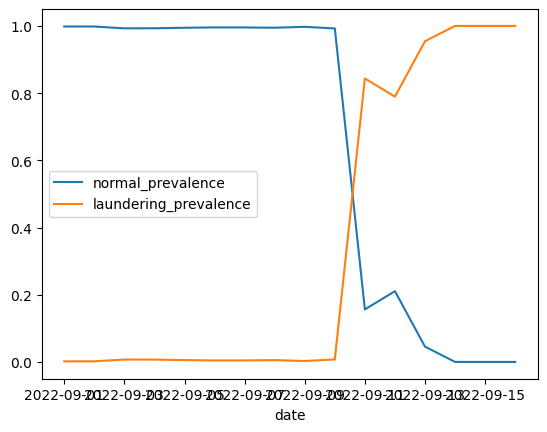

In [ ]:
import pandas as pd
import os

DRIVE_DIR = '/content/drive/MyDrive/AML'
PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/HI_Small')
# Assuming the processed data for US Dollar is the target
CURRENCY_DIR = os.path.join(PROCESSED_DIR, 'US_Dollar')
NORMAL_TX_PARQUET = os.path.join(CURRENCY_DIR, '1_filtered_normal_transactions.parquet')
LAUNDERING_TX_PARQUET = os.path.join(CURRENCY_DIR, '2_filtered_laundering_transactions.parquet')


try:
    # Load data from parquet files
    df_normal = pd.read_parquet(NORMAL_TX_PARQUET)
    df_laundering = pd.read_parquet(LAUNDERING_TX_PARQUET)

    # Concatenate the two dataframes
    df = pd.concat([df_normal, df_laundering], ignore_index=True)

    # Ensure timestamp is datetime and handle potential errors (already done in preprocessing, but good practice)
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
         df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    df = df.dropna(subset=['timestamp'])
    df['date'] = df['timestamp'].dt.date

    # is_laundering should already be int from preprocessing, but ensure
    if not pd.api.types.is_integer_dtype(df['is_laundering']):
        df['is_laundering'] = pd.to_numeric(df['is_laundering'], errors='coerce').fillna(0).astype(int)

    daily_counts = df.groupby(['date', 'is_laundering']).size().unstack(fill_value=0)
    daily_counts.columns = ['normal_count', 'laundering_count']

    daily_counts['total_count'] = daily_counts['normal_count'] + daily_counts['laundering_count']

    daily_counts['normal_prevalence'] = daily_counts['normal_count'] / daily_counts['total_count'].replace(0, pd.NA)
    daily_counts['laundering_prevalence'] = daily_counts['laundering_count'] / daily_counts['total_count'].replace(0, pd.NA)


    print("Daily Transaction Counts and Prevalence (Head):")
    display(daily_counts)

    daily_counts[['normal_prevalence', 'laundering_prevalence']].plot(kind='line')
    plt.title('Daily Prevalence of Normal and Laundering Transactions Over Time (LI-Small)')
    plt.xlabel('Date')
    plt.ylabel('Prevalence')
    plt.show()


except FileNotFoundError as e:
    print(f"Error: Processed data file not found: {e}")
except Exception as e:
    print(f"An error occurred while processing the data: {e}")

In [ ]:
import os
from pathlib import Path
import os
import re
import duckdb
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
DRIVE_DIR = '/content/drive/MyDrive/AML'

#PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/')

# HI small
#PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/small')

# LI small
DRIVE_BASE = Path('/content/drive/MyDrive/AML/processed/LI_Small/US_Dollar')
PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/LI_Small')

os.makedirs(PROCESSED_DIR, exist_ok=True)

print("Normal transactions")
df = pd.read_parquet(DRIVE_BASE / '1_filtered_normal_transactions.parquet')
print(df.head())
print("Laundering transactions")
df = pd.read_parquet(DRIVE_BASE / '2_filtered_laundering_transactions.parquet')
print(df.head())
print("Bank accounts")
df = pd.read_parquet(DRIVE_BASE / '3_filtered_accounts.parquet')
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Normal transactions
            timestamp from_bank from_account to_bank to_account  \
0 2022-09-01 00:17:00       011    800059120   01217  8006AD4E0   
1 2022-09-01 00:29:00     03618    800929EA0  001277  800929EF0   
2 2022-09-01 00:08:00     00394    80093BDB0  021414  80092A6C0   
3 2022-09-01 00:23:00     01231    800B69730  021414  80093CED0   
4 2022-09-01 00:19:00     02860    800BA6B40  011222  800BBE6F0   

   amount_received currency_received  amount_sent currency_sent payment_type  \
0         60562.00         US Dollar     60562.00     US Dollar          ACH   
1             0.05         US Dollar         0.05     US Dollar          ACH   
2         64335.00         US Dollar     64335.00     US Dollar          ACH   
3           217.00         US Dollar       217.00     US Dollar          ACH   
4          3400.37         US Dollar      3400.3

In [1]:
!pip install python-igraph leidenalg fastparquet
!pip install -q condacolab
import condacolab

condacolab.install_from_url("https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh")
!mamba install -q graph-tool
import graph_tool.all as gt, igraph as ig, leidenalg as la

  Using cached python_igraph-0.11.9-py3-none-any.whl.metadata (3.1 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached fastparquet-2024.11.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached igraph-0.11.9-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8 kB)
Using cached python_igraph-0.11.9-py3-none-any.whl (9.2 kB)
Using cached igraph-0.11.9-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.4 MB)
Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
Using cached fastparquet-2024.11.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 103.3 MB/s eta 0:00:00
Using cached texttable-1.7

In [11]:
import numpy as np
import pandas as pd
import datetime
from pathlib import Path
from datetime import timedelta
from collections import OrderedDict

from google.colab import drive
import graph_tool.all as gt
import igraph as ig
import leidenalg as la
from sklearn.metrics import average_precision_score

drive.mount('/content/drive', force_remount=False)

#DRIVE_BASE = Path('/content/drive/MyDrive/AML/processed/LI_Large/US_Dollar')
DRIVE_BASE = Path('/content/drive/MyDrive/AML/processed/LI_Small/US_Dollar')

proc = DRIVE_BASE
p_norm = proc / '1_filtered_normal_transactions.parquet'
p_pos  = proc / '2_filtered_laundering_transactions.parquet'
p_acct = proc / '3_filtered_accounts.parquet'

# Windows
WINDOW_DAYS_LIST = [3, 7]
WINDOW_STRIDE_DAYS = 1
MAX_WINDOWS_PER_SETTING = None  # set None to process all windows

# Communities config
LEIDEN_RESOLUTION = 1.0
LOUVAIN_SEED = 42
COMMUNITY_WEIGHTED = True

# Metrics configs
SKLEARN_OK = True
RUN_HITS = True
METRICS_DIR = proc / "metrics"
METRICS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_CSV = METRICS_DIR / "window_metrics.csv"

K_FRACS = (0.005, 0.01, 0.02)   # 0.5%, 1%, 2% for precision@k and attempt coverage
SEED_CUTOFF_FRAC = 0.2          # first 20% of timeline for global seeds

# PPR speed config
PPR_WEIGHTED = False            # if True, use 'w_amount_log' as edge weights; unweighted is faster
PPR_ALPHA = 0.85                # 0.85 converges faster than 0.9
PPR_HOPS = 2                    # k-hop subgraph around seeds (2 or 3 recommended)
PPR_BIDIR = False               # include IN neighbors too? (union of OUT and IN); False is faster
PPR_MAX_NODES = 40000           # cap subgraph size
PPR_MAX_SEEDS = 1000            # cap number of seed nodes (keep first N)

def to_cents(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors='coerce').mul(100).round().astype('Int64')

def init_base_props(G: gt.Graph):
    # Vertex props
    G.vp['name']    = G.new_vertex_property('string')
    G.vp['bank_id'] = G.new_vertex_property('string')
    G.vp['entity_id'] = G.new_vertex_property('string')
    G.vp['entity_name'] = G.new_vertex_property('string')
    G.vp['is_laundering_involved'] = G.new_vertex_property('int32_t', vals=0)
    # Edge props for aggregated graphs
    G.ep['w_count'] = G.new_edge_property('int64_t', vals=0)
    G.ep['w_amount'] = G.new_edge_property('int64_t', vals=0)       # amount received
    G.ep['w_amount_sent'] = G.new_edge_property('int64_t', vals=0)  # amount sent
    G.ep['w_amount_log'] = G.new_edge_property('double', vals=0.0)

def init_agg_vertex_props(G: gt.Graph):
    G.vp['in_amount_sum'] = G.new_vertex_property('int64_t', vals=0)
    G.vp['out_amount_sum'] = G.new_vertex_property('int64_t', vals=0)
    G.vp['in_deg'] = G.new_vertex_property('int32_t', vals=0)
    G.vp['out_deg'] = G.new_vertex_property('int32_t', vals=0)
    G.vp['in_tx_count'] = G.new_vertex_property('int64_t', vals=0)
    G.vp['out_tx_count'] = G.new_vertex_property('int64_t', vals=0)
    G.vp['in_out_amount_ratio'] = G.new_vertex_property('double', vals=0.0)

def window_stats(df_slice: pd.DataFrame, exclude_nodes: set | None = None):
    """
    Fast degeneracy check using df_slice only.
    Returns:
      total_nodes, pos_nodes, neg_nodes, eval_nodes, eval_pos_nodes, eval_neg_nodes
    """
    if df_slice is None or len(df_slice) == 0:
        return 0, 0, 0, 0, 0, 0

    u = df_slice['from_account'].astype(str).to_numpy(copy=False)
    v = df_slice['to_account'].astype(str).to_numpy(copy=False)
    all_nodes = pd.unique(np.concatenate([u, v]))

    pos_mask = (df_slice['is_laundering'] == 1)
    if pos_mask.any():
        up = df_slice.loc[pos_mask, 'from_account'].astype(str).to_numpy(copy=False)
        vp = df_slice.loc[pos_mask, 'to_account'].astype(str).to_numpy(copy=False)
        pos_nodes = pd.unique(np.concatenate([up, vp]))
    else:
        pos_nodes = np.array([], dtype=all_nodes.dtype)

    total = int(all_nodes.size)
    pos = int(pos_nodes.size)
    neg = total - pos

    if exclude_nodes:
        excl = set(exclude_nodes)
        eval_nodes_set = set(all_nodes) - excl
        eval_pos_set   = set(pos_nodes) - excl
        eval_nodes = len(eval_nodes_set)
        eval_pos_nodes = len(eval_pos_set)
        eval_neg_nodes = eval_nodes - eval_pos_nodes
    else:
        eval_nodes = total
        eval_pos_nodes = pos
        eval_neg_nodes = neg

    return total, pos, neg, eval_nodes, eval_pos_nodes, eval_neg_nodes

# -----------------------
# Data loading
# -----------------------
def load_processed():
    print("Loading processed data...")
    df_n = pd.read_parquet(p_norm)
    df_p = pd.read_parquet(p_pos)
    df = pd.concat([df_n, df_p], ignore_index=True)

    # Ensure timestamp is datetime and handle potential errors
    if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df = df.dropna(subset=['timestamp'])
    df.sort_values('timestamp', inplace=True)

    # Clean and engineer fields
    df['is_laundering'] = pd.to_numeric(df['is_laundering'], errors='coerce').fillna(0).astype('int8')
    df['amount_sent_c'] = to_cents(df['amount_sent'])
    df['amount_received_c'] = to_cents(df['amount_received'])
    df['same_bank'] = (df['from_bank'].astype(str) == df['to_bank'].astype(str))
    # Ensure string ids
    df['from_account'] = df['from_account'].astype(str)
    df['to_account'] = df['to_account'].astype(str)

    acct = pd.read_parquet(p_acct).drop_duplicates(subset=['account_id_hex'])
    acct['account_id_hex'] = acct['account_id_hex'].astype(str)
    acct.set_index('account_id_hex', inplace=True)
    return df, acct

def build_all_light():
    df, acct = load_processed()
    tmin, tmax = (df['timestamp'].min(), df['timestamp'].max())
    print(f"Loaded: {len(df):,} tx; accounts: {len(acct):,}")
    print(f"Time range: {tmin} → {tmax}")
    return df, acct, tmin, tmax

def iter_window_indices(ts, start, end, window_days=3, stride_days=1):
    cur = np.datetime64(start)
    end64 = np.datetime64(end)
    step = np.timedelta64(stride_days, 'D')
    wdur = np.timedelta64(window_days, 'D')
    while cur < end64:
        ws, we = cur, cur + wdur
        i0 = ts.searchsorted(ws, side='left')
        i1 = ts.searchsorted(we, side='left')
        yield i0, i1, pd.Timestamp(ws), pd.Timestamp(we)
        cur = cur + step

# -----------------------
# Graph aggregation
# -----------------------
def aggregate_graph_from_df(df_slice: pd.DataFrame, acct: pd.DataFrame, directed=False, include_reciprocated=False) -> gt.Graph:
    """
    Vectorized aggregation:
      - Directed: collapse by (u, v)
      - Undirected: collapse by sorted pair (a, b)
      - Edge props: w_count, w_amount (received), w_amount_sent, w_amount_log, reciprocated (if directed)
      - Vertex props: name, bank_id, entity_id, entity_name, is_laundering_involved
        + in/out amounts, degrees, tx counts, ratio
    """
    if df_slice is None or len(df_slice) == 0:
        H = gt.Graph(directed=directed)
        init_base_props(H); init_agg_vertex_props(H)
        return H

    u = df_slice['from_account'].astype(str).to_numpy(copy=False)
    v = df_slice['to_account'].astype(str).to_numpy(copy=False)
    amt_recv = pd.to_numeric(df_slice['amount_received_c'], errors='coerce').fillna(0).astype(np.int64).to_numpy(copy=False)
    amt_sent = pd.to_numeric(df_slice['amount_sent_c'], errors='coerce').fillna(0).astype(np.int64).to_numpy(copy=False)

    if directed:
        tmp = pd.DataFrame({'u': u, 'v': v, 'w_recv': amt_recv, 'w_sent': amt_sent})
        agg_e = tmp.groupby(['u', 'v'], sort=False, observed=False).agg(
            w_amount_recv=('w_recv','sum'),
            w_amount_sent=('w_sent','sum'),
            w_count=('u','size')
        ).reset_index()
        agg_e['w_amount'] = agg_e['w_amount_recv']
        edge_idx = pd.MultiIndex.from_frame(agg_e[['u', 'v']])
        rev_idx  = pd.MultiIndex.from_frame(agg_e[['v', 'u']])
        agg_e['reciprocated'] = edge_idx.isin(rev_idx).astype(np.int8)
        nodes = pd.unique(np.concatenate([agg_e['u'].to_numpy(), agg_e['v'].to_numpy()]))
    else:
        a = np.where(u <= v, u, v)
        b = np.where(u <= v, v, u)
        tmp = pd.DataFrame({'a': a, 'b': b, 'w': amt_recv})
        sum_df = tmp.groupby(['a', 'b'], sort=False, observed=False)['w'].sum().rename('w_amount')
        cnt_df = tmp.groupby(['a', 'b'], sort=False, observed=False).size().rename('w_count')
        agg_e = pd.concat([sum_df, cnt_df], axis=1).reset_index()
        nodes = pd.unique(np.concatenate([agg_e['a'].to_numpy(), agg_e['b'].to_numpy()]))

    agg_e['w_amount_log'] = np.log1p(agg_e['w_amount']).astype(np.float64)

    H = gt.Graph(directed=directed)
    init_base_props(H)
    init_agg_vertex_props(H)
    if directed and include_reciprocated:
        H.ep['reciprocated'] = H.new_edge_property('int8_t', vals=0)

    n = len(nodes)
    H.add_vertex(n)

    names_list = [str(x) for x in nodes]
    sub_acct = acct.reindex(names_list)

    # Assign vertex properties from DataFrame
    name_prop = H.vp['name']
    bank_prop = H.vp['bank_id']
    entid_prop = H.vp['entity_id']
    entname_prop = H.vp['entity_name']

    # Index map for node -> vertex idx
    idx = {names_list[i]: i for i in range(n)}

    for i, node_name in enumerate(names_list):
        v = H.vertex(i)
        name_prop[v] = node_name
        if node_name in sub_acct.index:
            acct_row = sub_acct.loc[node_name]
            bank_prop[v] = str(acct_row.get('bank_id', ''))
            entid_prop[v] = str(acct_row.get('entity_id', ''))
            entname_prop[v] = str(acct_row.get('entity_name', ''))
        else:
            bank_prop[v] = ''
            entid_prop[v] = ''
            entname_prop[v] = ''


    # Add edges with numeric properties
    if directed:
        src = agg_e['u'].map(idx).astype(np.int64).to_numpy()
        dst = agg_e['v'].map(idx).astype(np.int64).to_numpy()
        if include_reciprocated:
            edge_tbl = np.column_stack([
                src, dst,
                agg_e['w_count'].to_numpy(np.int64),
                agg_e['w_amount'].to_numpy(np.int64),       # received
                agg_e['w_amount_sent'].to_numpy(np.int64),  # sent
                agg_e['w_amount_log'].to_numpy(np.float64),
                agg_e['reciprocated'].to_numpy(np.int8),
            ])
            edge_props = [
                H.ep['w_count'], H.ep['w_amount'], H.ep['w_amount_sent'],
                H.ep['w_amount_log'], H.ep['reciprocated']
            ]
        else:
            edge_tbl = np.column_stack([
                src, dst,
                agg_e['w_count'].to_numpy(np.int64),
                agg_e['w_amount'].to_numpy(np.int64),
                agg_e['w_amount_sent'].to_numpy(np.int64),
                agg_e['w_amount_log'].to_numpy(np.float64),
            ])
            edge_props = [H.ep['w_count'], H.ep['w_amount'], H.ep['w_amount_sent'], H.ep['w_amount_log']]
    else:
        src = agg_e['a'].map(idx).astype(np.int64).to_numpy()
        dst = agg_e['b'].map(idx).astype(np.int64).to_numpy()
        edge_tbl = np.column_stack([
            src, dst,
            agg_e['w_count'].to_numpy(np.int64),
            agg_e['w_amount'].to_numpy(np.int64),
            agg_e['w_amount_log'].to_numpy(np.float64),
        ])
        edge_props = [H.ep['w_count'], H.ep['w_amount'], H.ep['w_amount_log']]

    H.add_edge_list(edge_tbl, eprops=edge_props)
    # Label laundering-involved vertices
    pos_mask = df_slice['is_laundering'] == 1
    pos_nodes = np.array([], dtype=object)
    if pos_mask.any():
        pos_nodes = pd.unique(np.concatenate([
            df_slice.loc[pos_mask, 'from_account'].astype(str).to_numpy(),
            df_slice.loc[pos_mask, 'to_account'].astype(str).to_numpy()
        ]))
    involved = H.vp['is_laundering_involved']
    arr_involv = np.zeros(n, dtype=np.int32)
    for acc in pos_nodes:
        j = idx.get(acc, None)
        if j is not None:
            arr_involv[j] = 1
    involved.a = arr_involv

    # Vertex-level sums and degrees
    in_amount_sum = H.vp['in_amount_sum']; out_amount_sum = H.vp['out_amount_sum']
    in_deg = H.vp['in_deg']; out_deg = H.vp['out_deg']
    in_tx_count = H.vp['in_tx_count']; out_tx_count = H.vp['out_tx_count']
    in_out_ratio = H.vp['in_out_amount_ratio']

    if directed:
        in_amt_map  = agg_e.groupby('v')['w_amount_recv'].sum().to_dict()
        out_amt_map = agg_e.groupby('u')['w_amount_sent'].sum().to_dict()
        in_tx_map   = agg_e.groupby('v')['w_count'].sum().to_dict()
        out_tx_map  = agg_e.groupby('u')['w_count'].sum().to_dict()
        in_deg_map  = agg_e.groupby('v').size().to_dict()
        out_deg_map = agg_e.groupby('u').size().to_dict()

        arr_in_amt  = np.zeros(n, dtype=np.int64); arr_out_amt = np.zeros(n, dtype=np.int64)
        arr_in_tx   = np.zeros(n, dtype=np.int64); arr_out_tx  = np.zeros(n, dtype=np.int64)
        arr_in_deg  = np.zeros(n, dtype=np.int32); arr_out_deg = np.zeros(n, dtype=np.int32)

        for k, val in in_amt_map.items():  arr_in_amt[idx[k]]  = int(val)
        for k, val in out_amt_map.items(): arr_out_amt[idx[k]] = int(val)
        for k, val in in_tx_map.items():   arr_in_tx[idx[k]]   = int(val)
        for k, val in out_tx_map.items():  arr_out_tx[idx[k]]  = int(val)
        for k, val in in_deg_map.items():  arr_in_deg[idx[k]]  = int(val)
        for k, val in out_deg_map.items(): arr_out_deg[idx[k]] = int(val)

        in_amount_sum.a = arr_in_amt;  out_amount_sum.a = arr_out_amt
        in_tx_count.a   = arr_in_tx;   out_tx_count.a   = arr_out_tx
        in_deg.a        = arr_in_deg;  out_deg.a        = arr_out_deg
        in_out_ratio.a  = (arr_in_amt + 1.0) / (arr_out_amt + 1.0)
    else:
        # undirected: in == out
        deg_a = agg_e.groupby('a').size().to_dict()
        deg_b = agg_e.groupby('b').size().to_dict()
        amt_a = agg_e.groupby('a')['w_amount'].sum().to_dict()
        amt_b = agg_e.groupby('b')['w_amount'].sum().to_dict()
        tx_a  = agg_e.groupby('a')['w_count'].sum().to_dict()
        tx_b  = agg_e.groupby('b')['w_count'].sum().to_dict()

        arr_deg = np.zeros(n, dtype=np.int32)
        arr_amt = np.zeros(n, dtype=np.int64)
        arr_tx  = np.zeros(n, dtype=np.int64)

        for k, val in deg_a.items(): arr_deg[idx[k]] += int(val)
        for k, val in deg_b.items(): arr_deg[idx[k]] += int(val)
        for k, val in amt_a.items(): arr_amt[idx[k]] += int(val)
        for k, val in amt_b.items(): arr_amt[idx[k]] += int(val)
        for k, val in tx_a.items():  arr_tx[idx[k]]  += int(val)
        for k, val in tx_b.items():  arr_tx[idx[k]]  += int(val)

        in_deg.a = arr_deg;  out_deg.a = arr_deg
        in_amount_sum.a = arr_amt; out_amount_sum.a = arr_amt
        in_tx_count.a = arr_tx; out_tx_count.a = arr_tx
        in_out_ratio.a = np.ones(n, dtype=np.float64)

    return H

# igraph conversion cache
IG_CACHE = OrderedDict()
IG_CACHE_MAX = 8

def to_igraph(H: gt.Graph, use_weight=False, weight_name='w_amount_log', cache=True):
    key = (id(H), use_weight, weight_name, H.is_directed())
    if cache and key in IG_CACHE:
        g = IG_CACHE.pop(key); IG_CACHE[key] = g; return g

    n = H.num_vertices()
    attrs = []
    if use_weight and (weight_name in H.ep):
        attrs.append(H.ep[weight_name])
    if 'w_amount' in H.ep:
        attrs.append(H.ep['w_amount'])
    if 'w_amount_sent' in H.ep and H.is_directed():
        attrs.append(H.ep['w_amount_sent'])

    if attrs:
        ed = H.get_edges(eprops=attrs)
        edges = [(int(a), int(b)) for a, b in ed[:, :2].astype(int)]
        col = 2
        w = None; amt = None; amt_sent = None
        if use_weight and (weight_name in H.ep):
            w = [float(x) for x in ed[:, col].astype(float)]; col += 1
        if 'w_amount' in H.ep:
            amt = [float(x) for x in ed[:, col].astype(float)]; col += 1
        if 'w_amount_sent' in H.ep and H.is_directed():
            amt_sent = [float(x) for x in ed[:, col].astype(float)]; col += 1
    else:
        ed = H.get_edges()
        edges = [(int(a), int(b)) for a, b in ed.astype(int)]
        w = None; amt = None; amt_sent = None

    g = ig.Graph(n=n, edges=edges, directed=H.is_directed())
    if w is not None:
        g.es['weight'] = w
    if amt is not None:
        g.es['amount'] = amt
    if amt_sent is not None:
        g.es['amount_sent'] = amt_sent

    g.vs['name'] = [H.vp['name'][H.vertex(i)] for i in range(n)]
    if cache:
        IG_CACHE[key] = g
        if len(IG_CACHE) > IG_CACHE_MAX:
            IG_CACHE.popitem(last=False)
    return g

# Attempt mapping (vectorized)
def get_attempt_nodes_map_df(df_slice: pd.DataFrame) -> dict:
    if df_slice is None or len(df_slice) == 0:
        return {}
    pos = df_slice['is_laundering'] == 1
    dfp = df_slice.loc[pos, ['attempt_id', 'from_account', 'to_account']].dropna(subset=['attempt_id'])
    if dfp.empty:
        return {}
    dfp['attempt_id'] = dfp['attempt_id'].astype(str)
    g = dfp.groupby('attempt_id')
    att_nodes = {}
    for att_id, grp in g:
        att_nodes[att_id] = set(grp['from_account'].astype(str)).union(set(grp['to_account'].astype(str)))
    return att_nodes

# Metrics helpers
def precision_at_k(y_true, y_score, k_frac=0.01):
    y_true = np.asarray(y_true); y_score = np.asarray(y_score)
    n = max(1, int(len(y_true) * k_frac))
    idx = np.argsort(-y_score)[:n]
    return float(y_true[idx].mean())

def get_node_names(G: gt.Graph):
    return [G.vp['name'][v] for v in G.vertices()]

def vprop_to_dict(G: gt.Graph, prop_name: str):
    prop = G.vp[prop_name]
    name = G.vp['name']
    return {name[v]: prop[v] for v in G.vertices()}

def eval_scores(nodes, y_true_dict, score_dict, k_fracs=(0.005, 0.01, 0.02), exclude_nodes=None):
    if exclude_nodes is None: exclude_nodes = set()
    eval_nodes = [n for n in nodes if n not in exclude_nodes]
    y_true = np.array([int(y_true_dict.get(n, 0)) for n in eval_nodes], dtype=int)
    res = {}
    for name, s in score_dict.items():
        scores = np.array([float(s.get(n, 0.0)) for n in eval_nodes], dtype=float)
        ap = average_precision_score(y_true, scores) if SKLEARN_OK and len(set(y_true)) > 1 else None
        metrics = {'ap': ap}
        metrics['_eval_nodes'] = len(eval_nodes)
        # Calculate eval_pos_count by summing the boolean values of y_true
        eval_pos_count = int(np.sum(y_true))
        metrics['_eval_pos'] = eval_pos_count

        for k in k_fracs:
            metrics[f"p_at_{pct_key(k)}"] = precision_at_k(y_true, scores, k)
        order = np.argsort(-scores)
        metrics['_ranked_nodes'] = [eval_nodes[i] for i in order]
        res[name] = metrics
    return res

def run_centrality_baselines(H_dir: gt.Graph):
    scores = {}
    w = H_dir.ep.get('w_amount_log', None)
    try:
        pr = gt.pagerank(H_dir, damping=0.9, weight=w)
        names = H_dir.vp['name']
        scores['pagerank_wlog'] = {names[v]: float(pr[v]) for v in H_dir.vertices()}
    except Exception:
        scores['pagerank_wlog'] = {}

    if RUN_HITS:
        try:
            hubs, auth = gt.hits(H_dir, weight=w)
            names = H_dir.vp['name']
            scores['hits_hub'] = {names[v]: float(hubs[v]) for v in H_dir.vertices()}
            scores['hits_auth'] = {names[v]: float(auth[v]) for v in H_dir.vertices()}
        except Exception:
            scores['hits_hub'] = {}; scores['hits_auth'] = {}
    else:
        scores['hits_hub'] = {}; scores['hits_auth'] = {}

    for k_prop, name in [
        ('in_deg', 'in_deg'), ('out_deg', 'out_deg'),
        ('in_tx_count', 'in_tx'), ('out_tx_count', 'out_tx'),
        ('in_amount_sum', 'in_amt'), ('out_amount_sum', 'out_amt'),
    ]:
        try:
            scores[name] = vprop_to_dict(H_dir, k_prop)
        except Exception:
            scores[name] = {}
    try:
        in_amt = H_dir.vp['in_amount_sum']; out_amt = H_dir.vp['out_amount_sum']; names = H_dir.vp['name']
        scores['collector'] = {names[v]: float(in_amt[v]) / (float(out_amt[v]) + 1.0) for v in H_dir.vertices()}
        scores['distributor'] = {names[v]: float(out_amt[v]) / (float(in_amt[v]) + 1.0) for v in H_dir.vertices()}
    except Exception:
        scores['collector'] = {}; scores['distributor'] = {}
    return scores

def membership_to_comms(membership, names):
    k = max(membership) + 1 if membership else 0
    comms = [set() for _ in range(k)]
    for i, cid in enumerate(membership):
        comms[cid].add(names[i])
    return comms

def score_communities_fast_igraph(g, membership, min_size=2, amount_attr='amount', use_global_clustering=True):
    """
    Fast community scorer:
      - density: #intra edges / max edges
      - amount: sum of edge attribute (default: 'amount')
      - clustering: optional, computed once globally then averaged per community
    """
    n = g.vcount()
    if n == 0:
        return {}
    memb = np.asarray(membership, dtype=np.int64)
    K = int(memb.max()) + 1 if memb.size else 0
    size_by_c = np.bincount(memb, minlength=K)

    E = np.array(g.get_edgelist(), dtype=np.int64)
    if E.size == 0:
        return {cid: 0.0 for cid in range(K)}
    has_amount = amount_attr in g.es.attributes()
    w = np.asarray(g.es[amount_attr], dtype=float) if has_amount else np.ones(E.shape[0], dtype=float)

    cid_u = memb[E[:, 0]]
    cid_v = memb[E[:, 1]]
    mask_intra = (cid_u == cid_v)

    e_intra = np.bincount(cid_u[mask_intra], minlength=K)
    amt_intra = np.bincount(cid_u[mask_intra], weights=w[mask_intra], minlength=K)

    if use_global_clustering:
        try:
            cl = np.array(g.transitivity_local_undirected(mode="zero"), dtype=float)
            cl = np.nan_to_num(cl, nan=0.0, posinf=0.0, neginf=0.0)
        except Exception:
            cl = np.zeros(n, dtype=float)
        cl_sum = np.bincount(memb, weights=cl, minlength=K)
        cl_avg = np.divide(cl_sum, np.maximum(1, size_by_c), where=(size_by_c > 0))
    else:
        cl_avg = np.zeros(K, dtype=float)

    scores = {}
    for cid in range(K):
        n_c = int(size_by_c[cid])
        if n_c < min_size:
            scores[cid] = 0.0
            continue
        max_edges = n_c * (n_c - 1) / 2.0
        density = float(e_intra[cid]) / max_edges if max_edges > 0 else 0.0
        amount_score = min(1.0, float(np.log1p(amt_intra[cid]) / 20.0))
        size_boost = float(1.0 - np.exp(-n_c / 10.0))
        scores[cid] = (0.35 * density + 0.2 * float(cl_avg[cid]) + 0.45 * amount_score) * size_boost
    return scores

def compute_communities_fast(H_agg, resolution=1.0, seed=42):
    """
    Returns:
      {
        'louvain': {'comms': list[set], 'scores': dict, 'avg': float},
        'leiden':  {'comms': list[set], 'scores': dict, 'avg': float},
        'ranked_cache': dict[(tag, kf)] -> list[node_name]
      }
    """
    g_und = to_igraph(H_agg, use_weight=(COMMUNITY_WEIGHTED and ('w_amount_log' in H_agg.ep)), weight_name='w_amount_log', cache=False)
    names_und = g_und.vs['name']
    has_weight = 'weight' in g_und.es.attributes()
    has_amount = 'amount' in g_und.es.attributes()
    try:
        ig.random.seed(seed)
    except Exception:
        pass
    np.random.seed(seed)

    # Louvain
    cl_louv = g_und.community_multilevel(weights=g_und.es['weight'] if has_weight else None)
    memb_louv = cl_louv.membership
    comms_louv = membership_to_comms(memb_louv, names_und)
    scores_louv = score_communities_fast_igraph(
        g_und, memb_louv, min_size=3,
        amount_attr='amount' if has_amount else ('weight' if has_weight else None),
        use_global_clustering=True
    )
    avg_louv = float(np.mean(list(scores_louv.values()))) if scores_louv else 0.0

    # Leiden
    part = la.RBConfigurationVertexPartition(
        g_und,
        weights='weight' if has_weight else None,
        resolution_parameter=resolution
    )
    opt = la.Optimiser()
    opt.set_rng_seed(seed)
    opt.optimise_partition(part)
    memb_leid = part.membership
    comms_leid = membership_to_comms(memb_leid, names_und)
    scores_leid = score_communities_fast_igraph(
        g_und, memb_leid, min_size=3,
        amount_attr='amount' if has_amount else ('weight' if has_weight else None),
        use_global_clustering=True
    )
    avg_leid = float(np.mean(list(scores_leid.values()))) if scores_leid else 0.0

    # Pre-rank for coverage metrics
    ranked_cache = {}
    for tag, comms, scores in [('louvain', comms_louv, scores_louv), ('leiden', comms_leid, scores_leid)]:
        if scores:
            comm_order = sorted(scores.items(), key=lambda x: x[1], reverse=True)
            total_nodes = g_und.vcount()
            acc = set()
            for kf in K_FRACS:
                target = max(1, int(total_nodes * kf))
                acc.clear()
                for cid, _score in comm_order:
                    acc |= comms[cid]
                    if len(acc) >= target:
                        break
                ranked_cache[(tag, kf)] = list(acc)

    return {
        'louvain': {'comms': comms_louv, 'scores': scores_louv, 'avg': avg_louv},
        'leiden':  {'comms': comms_leid, 'scores': scores_leid, 'avg': avg_leid},
        'ranked_cache': ranked_cache
    }

def get_seeded_pagerank_scores(H_agg_dir: gt.Graph, seed_nodes: set, weight='w_amount_log', alpha=None):
    """
    Fast personalized PageRank using igraph.
    """
    if not seed_nodes:
        return {}
    # Trim seeds to cap
    if PPR_MAX_SEEDS is not None and len(seed_nodes) > PPR_MAX_SEEDS:
        seed_nodes = set(list(sorted(seed_nodes))[:PPR_MAX_SEEDS])

    # igraph path
    g = to_igraph(H_agg_dir, use_weight=PPR_WEIGHTED, weight_name=weight, cache=False)
    seeds_idx = g.vs.select(name_in=list(seed_nodes)).indices
    if len(seeds_idx) == 0:
        return {}

    # k-hop neighborhood
    mode_out = ig.OUT
    keep = set()
    for lst in g.neighborhood(seeds_idx, order=PPR_HOPS, mode=mode_out):
        keep.update(lst)
    if PPR_BIDIR:
        for lst in g.neighborhood(seeds_idx, order=PPR_HOPS, mode=ig.IN):
            keep.update(lst)
    keep.update(seeds_idx)

    # Cap subgraph size
    keep_idx = list(keep)
    if PPR_MAX_NODES is not None and len(keep_idx) > PPR_MAX_NODES:
        deg = g.degree(keep_idx, mode=ig.ALL)
        order = np.argsort(-np.asarray(deg))
        cap = max(1, PPR_MAX_NODES - len(seeds_idx))
        selected = set(seeds_idx) | {keep_idx[i] for i in order[:cap]}
        keep_idx = list(selected)

    sub = g.induced_subgraph(keep_idx)
    sub_names = sub.vs['name']
    sub_seeds_idx = sub.vs.select(name_in=list(seed_nodes)).indices
    if len(sub_seeds_idx) == 0:
        return {name: 0.0 for name in sub_names}

    reset = np.zeros(sub.vcount(), dtype=float)
    reset[sub_seeds_idx] = 1.0 / len(sub_seeds_idx)

    alpha_eff = PPR_ALPHA if alpha is None else alpha
    weights_key = 'weight' if (PPR_WEIGHTED and 'weight' in sub.es.attributes()) else None
    pr = sub.personalized_pagerank(damping=alpha_eff, reset=reset, weights=weights_key, directed=True)
    scores = {name: float(score) for name, score in zip(sub_names, pr)}
    return scores

def attempt_coverage(nodes_ranked, attempt_nodes_map: dict, k_frac=0.01):
    if not attempt_nodes_map:
        return None
    N = len(nodes_ranked); k = max(1, int(N * k_frac))
    top = set(nodes_ranked[:k])
    covered = sum(1 for nodes in attempt_nodes_map.values() if top & nodes)
    return covered / max(1, len(attempt_nodes_map))

def pretty_metrics(results: dict):
    def is_num(x):
        return isinstance(x, (int, float, np.integer, np.floating))
    out = {}
    for method, metr in results.items():
        out[method] = {}
        for k, v in metr.items():
            if str(k).startswith('_'):
                continue
            if v is None:
                out[method][k] = None
            elif is_num(v):
                out[method][k] = round(float(v), 4)
            else:
                out[method][k] = v
    return out

def pct_key(kf: float) -> str:
    return f"{kf*100:.1f}pct"

# Build data
df, acct, tmin, tmax = build_all_light()
ts = df['timestamp'].to_numpy()

# Temporal windows quick summary (vectorized)
for window_days in WINDOW_DAYS_LIST:
    print(f"\n-- {window_days}-day windows, stride={WINDOW_STRIDE_DAYS}d --")
    for i, (i0, i1, ws, we) in enumerate(iter_window_indices(ts, tmin, tmax, window_days=window_days, stride_days=WINDOW_STRIDE_DAYS)):
        df_slice = df.iloc[i0:i1]
        if df_slice.empty:
            continue
        nodes_win = pd.unique(np.concatenate([df_slice['from_account'].to_numpy(), df_slice['to_account'].to_numpy()]))
        pos_e = int((df_slice['is_laundering'] == 1).sum())
        pos_nodes_win = len(pd.unique(np.concatenate([
            df_slice.loc[df_slice['is_laundering']==1, 'from_account'].to_numpy(),
            df_slice.loc[df_slice['is_laundering']==1, 'to_account'].to_numpy()
        ])))
        print(f"[{i:03d}] {ws:%Y-%m-%d} → {we:%Y-%m-%d}: nodes={len(nodes_win):,}, edges={len(df_slice):,}, pos_edges={pos_e:,}, pos_nodes={pos_nodes_win:,}")
        if MAX_WINDOWS_PER_SETTING is not None and i + 1 >= MAX_WINDOWS_PER_SETTING:
            break

# Full-period community baselines (Louvain + Leiden)
H_full = aggregate_graph_from_df(df, acct, directed=False)
print(f"\nEnhanced community baselines on full period:")
print(f"Aggregated graph: {H_full.num_vertices():,} nodes, {H_full.num_edges():,} edges")

comm_full = compute_communities_fast(H_full, resolution=LEIDEN_RESOLUTION, seed=LOUVAIN_SEED)

print("Louvain (igraph) communities (top 5 by heuristic score):")
scores_louv = comm_full['louvain']['scores']
comms_louv = comm_full['louvain']['comms']
for cid, score in sorted(scores_louv.items(), key=lambda x: x[1], reverse=True)[:5]:
    size = len(comms_louv[cid]) if cid < len(comms_louv) else 0
    print(f"  LVN cid={cid:>4}  score={score:.3f}  size={size:>6}")

print("Leiden (igraph) communities (top 5 by heuristic score):")
scores_leid = comm_full['leiden']['scores']
comms_leid = comm_full['leiden']['comms']
for cid, score in sorted(scores_leid.items(), key=lambda x: x[1], reverse=True)[:5]:
    size = len(comms_leid[cid]) if cid < len(comms_leid) else 0
    print(f"  LDN cid={cid:>4}  score={score:.3f}  size={size:>6}")

# Build fixed time-based seeds
if tmin is None or tmax is None:
    raise RuntimeError("Time range unavailable; cannot build seeds.")
T = tmin + (tmax - tmin) * SEED_CUTOFF_FRAC
df_seed = df[(df['timestamp'] >= tmin) & (df['timestamp'] < T)]
seed_nodes_global = set(pd.unique(np.concatenate([
    df_seed.loc[df_seed['is_laundering']==1, 'from_account'].astype(str).to_numpy(),
    df_seed.loc[df_seed['is_laundering']==1, 'to_account'].astype(str).to_numpy()
])))
print(f"Global seeds cutoff T={T} | seed_nodes={len(seed_nodes_global)}")

# Single-pass: compute metrics and preview
rows = []
print("\nProcessing windows (metrics + preview):")
for window_days in WINDOW_DAYS_LIST:
    print(f"\n-- {window_days}-day windows --")
    skipped = 0
    count = 0

    for i0, i1, ws, we in iter_window_indices(ts, tmin, tmax, window_days, WINDOW_STRIDE_DAYS):
        df_slice = df.iloc[i0:i1]
        if df_slice.empty:
            continue

        # Fast degeneracy check before any graph work
        total_nodes, total_pos_nodes, total_neg_nodes, eval_nodes_sp, eval_pos_sp, eval_neg_sp = window_stats(
            df_slice, exclude_nodes=(seed_nodes_global if (ws >= T and seed_nodes_global) else None)
        )
        if total_nodes == 0 or total_neg_nodes <= 0:
            skipped += 1
            print(f"[{ws:%Y-%m-%d} → {we:%Y-%m-%d}] Skipping degenerate window (all-positive or no negatives).")
            continue

        # Build graphs once
        H_agg = aggregate_graph_from_df(df_slice, acct, directed=False)
        H_agg_dir = aggregate_graph_from_df(df_slice, acct, directed=True)

        # Prepare common data
        nodes = get_node_names(H_agg_dir)
        y_true_dict = vprop_to_dict(H_agg_dir, 'is_laundering_involved')
        pos_nodes_graph = int(sum(int(y_true_dict.get(n, 0)) for n in nodes))
        att_nodes_map = get_attempt_nodes_map_df(df_slice)

        # Centralities
        score_dict = run_centrality_baselines(H_agg_dir)
        results = eval_scores(nodes, y_true_dict, score_dict, k_fracs=K_FRACS)

        # Seeded PR (time-based seeds) — only if eval set after excluding seeds has negatives
        seeded_scores = None
        if ws >= T and seed_nodes_global and eval_nodes_sp > 0 and eval_neg_sp > 0:
            seeded_scores = get_seeded_pagerank_scores(H_agg_dir, seed_nodes_global, weight='w_amount_log', alpha=PPR_ALPHA)
            seeded_res = eval_scores(
                nodes, y_true_dict, {'seeded_pr': seeded_scores},
                k_fracs=K_FRACS, exclude_nodes=seed_nodes_global
            )
            results.update(seeded_res)

        # Communities (Louvain and Leiden), fast scorer
        comm = compute_communities_fast(H_agg, resolution=LEIDEN_RESOLUTION, seed=LOUVAIN_SEED)
        comm_ranked_nodes_cache = comm['ranked_cache']
        avg_comm_score_louv = comm['louvain']['avg']
        avg_comm_score_leid = comm['leiden']['avg']

        print(f"[{ws:%Y-%m-%d} → {we:%Y-%m-%d}] nodes={H_agg.num_vertices():,}, edges={H_agg.num_edges():,}")
        print("  Centrality baselines:", pretty_metrics(results))
        print(f"  Avg community score (Louvain): {avg_comm_score_louv:.4f} | (Leiden): {avg_comm_score_leid:.4f}")
        if seeded_scores is not None:
            eval_nodes_list = [n for n in nodes if n not in seed_nodes_global]
            y_true_eval = [int(y_true_dict.get(n, 0)) for n in eval_nodes_list]
            y_score_eval = [seeded_scores.get(n, 0.0) for n in eval_nodes_list]
            if SKLEARN_OK and len(set(y_true_eval)) > 1:
                pr_auc_win = average_precision_score(y_true_eval, y_score_eval)
                print(f"  PersonalizedPageRank PR-AUC: {pr_auc_win:.4f}")

        # Build per-method rows for CSV
        base = {
            'window_days': window_days, 'ws': ws, 'we': we,
            'nodes': int(H_agg_dir.num_vertices()), 'edges': int(H_agg_dir.num_edges()),
            'pos_nodes': pos_nodes_graph
        }
        for method, m in results.items():
            eval_nodes_count = int(m.get('_eval_nodes', len(nodes)))
            eval_pos_count = int(m.get('_eval_pos', sum(y_true_dict.get(n, 0) for n in nodes)))
            eval_neg_count = eval_nodes_count - eval_pos_count
            if eval_nodes_count <= 0 or eval_neg_count <= 0:
                continue

            row = dict(base)
            row['method'] = method
            row['ap'] = m.get('ap', None)
            row['eval_nodes'] = eval_nodes_count
            row['eval_pos_nodes'] = eval_pos_count
            row['prevalence_eval'] = eval_pos_count / eval_nodes_count

            for kf in K_FRACS:
                p_at_key = f"p_at_{pct_key(kf)}"
                attcov_key = f"attcov_at_{pct_key(kf)}"
                row[p_at_key] = m.get(p_at_key, None)
                ranked_nodes = m.get('_ranked_nodes', [])
                cov = attempt_coverage(ranked_nodes, att_nodes_map, k_frac=kf)
                row[attcov_key] = cov
            rows.append(row)

        # Community coverage rows (using ranked_cache)
        for tag in ['louvain', 'leiden']:
            if any((tag, kf) in comm_ranked_nodes_cache for kf in K_FRACS):
                row = dict(base); row['method'] = f'communities_unsup_{tag}'; row['ap'] = None
                row['eval_nodes'] = base['nodes']; row['eval_pos_nodes'] = base['pos_nodes']
                row['prevalence_eval'] = (base['pos_nodes'] / base['nodes']) if base['nodes'] > 0 else np.nan
                for kf in K_FRACS:
                    p_at_key = f"p_at_{pct_key(kf)}"
                    attcov_key = f"attcov_at_{pct_key(kf)}"
                    row[p_at_key] = None
                    cov = attempt_coverage(comm_ranked_nodes_cache[(tag, kf)], att_nodes_map, k_frac=1.0) if (tag, kf) in comm_ranked_nodes_cache else None
                    row[attcov_key] = cov
                rows.append(row)

        count += 1
        if MAX_WINDOWS_PER_SETTING is not None and count >= MAX_WINDOWS_PER_SETTING:
            break

    if skipped:
        print(f"Skipped {skipped} degenerate windows for {window_days}-day setting.")

df_metrics = pd.DataFrame(rows)
"""
# Per-window enhanced analysis (first few windows per setting):
print("\nPer-window enhanced analysis (first few windows per setting):")
for window_days in WINDOW_DAYS_LIST:
    print(f"\n-- {window_days}-day windows --")
    count = 0
    skipped = 0
    for i0, i1, ws, we in iter_window_indices(ts, tmin, tmax, window_days, WINDOW_STRIDE_DAYS):
        df_slice = df.iloc[i0:i1]
        if df_slice.empty:
            continue

        # Fast degeneracy check before any graph work
        total, pos, neg, eval_nodes_sp, eval_pos_sp, eval_neg_sp = window_stats(
            df_slice, exclude_nodes=(seed_nodes_global if (ws >= T and seed_nodes_global) else None)
        )
        if total == 0 or neg <= 0:
            skipped += 1
            print(f"[{ws:%Y-%m-%d} → {we:%Y-%m-%d}] Skipping degenerate window (all-positive or no negatives).")
            continue

        H_agg = aggregate_graph_from_df(df_slice, acct, directed=False)
        H_agg_dir = aggregate_graph_from_df(df_slice, acct, directed=True)

        # Centralities
        nodes = get_node_names(H_agg_dir)
        y_true_dict = vprop_to_dict(H_agg_dir, 'is_laundering_involved')
        score_dict = run_centrality_baselines(H_agg_dir)
        results = eval_scores(nodes, y_true_dict, score_dict, k_fracs=(0.005, 0.01, 0.02))
        print("  Centrality baselines:", pretty_metrics(results))

        # Communities
        comm = compute_communities_fast(H_agg, resolution=LEIDEN_RESOLUTION, seed=LOUVAIN_SEED)
        avg_comm_score_louv = comm['louvain']['avg']
        avg_comm_score_leid = comm['leiden']['avg']

        # Seeded PR only if there are negatives after excluding seeds
        pr_auc_win = None
        if ws >= T and seed_nodes_global and eval_nodes_sp > 0 and eval_neg_sp > 0:
            seeded_scores = get_seeded_pagerank_scores(H_agg_dir, seed_nodes_global, weight='w_amount_log', alpha=PPR_ALPHA)
            eval_nodes = [n for n in nodes if n not in seed_nodes_global]
            y_true = [int(y_true_dict.get(n, 0)) for n in eval_nodes]
            y_score = [seeded_scores.get(n, 0.0) for n in eval_nodes]
            if SKLEARN_OK and len(set(y_true)) > 1:
                pr_auc_win = average_precision_score(y_true, y_score)

        print(f"[{ws:%Y-%m-%d} → {we:%Y-%m-%d}] nodes={H_agg.num_vertices():,}, edges={H_agg.num_edges():,}")
        print(f"  Avg community score (Louvain): {avg_comm_score_louv:.4f} | (Leiden): {avg_comm_score_leid:.4f}")
        if pr_auc_win is not None:
            print(f"  PersonalizedPageRank PR-AUC: {pr_auc_win:.4f}")

        count += 1
        if MAX_WINDOWS_PER_SETTING is not None and count >= MAX_WINDOWS_PER_SETTING:
            break
    if skipped:
        print(f"Skipped {skipped} degenerate windows for {window_days}-day setting.")

# Full per-window metrics -> CSV
rows = []
for window_days in WINDOW_DAYS_LIST:
    count = 0
    for i0, i1, ws, we in iter_window_indices(ts, tmin, tmax, window_days, WINDOW_STRIDE_DAYS):
        df_slice = df.iloc[i0:i1]
        if df_slice.empty:
            continue

        # Fast degeneracy check using raw df (skip entire window if no negatives)
        total_nodes, total_pos_nodes, total_neg_nodes, eval_nodes_sp, eval_pos_sp, eval_neg_sp = window_stats(
            df_slice, exclude_nodes=(seed_nodes_global if (ws >= T and seed_nodes_global) else None)
        )
        if total_nodes == 0 or total_neg_nodes <= 0:
            continue  # skip window entirely

        # Build graphs only for non-degenerate windows
        H_agg = aggregate_graph_from_df(df_slice, acct, directed=False)
        H_agg_dir = aggregate_graph_from_df(df_slice, acct, directed=True)
        nodes = get_node_names(H_agg_dir)
        y_true_dict = vprop_to_dict(H_agg_dir, 'is_laundering_involved')
        att_nodes_map = get_attempt_nodes_map_df(df_slice)

        score_dict = run_centrality_baselines(H_agg_dir)
        results = eval_scores(nodes, y_true_dict, score_dict, k_fracs=K_FRACS)

        # Seeded PR: only compute if its eval set (after excluding seeds) has negatives
        if ws >= T and seed_nodes_global and eval_nodes_sp > 0 and eval_neg_sp > 0:
            seeded_scores = get_seeded_pagerank_scores(H_agg_dir, seed_nodes_global, weight='w_amount_log', alpha=PPR_ALPHA)
            seeded_res = eval_scores(nodes, y_true_dict, {'seeded_pr': seeded_scores}, k_fracs=K_FRACS, exclude_nodes=seed_nodes_global)
            results.update(seeded_res)

        # Communities (Louvain and Leiden), fast scorer
        comm = compute_communities_fast(H_agg, resolution=LEIDEN_RESOLUTION, seed=LOUVAIN_SEED)
        comm_ranked_nodes_cache = comm['ranked_cache']

        base = {
            'window_days': window_days, 'ws': ws, 'we': we,
            'nodes': total_nodes, 'edges': int(H_agg_dir.num_edges()),
            'pos_nodes': total_pos_nodes
        }

        # Add per-method rows only if that method's eval set has negatives (prevalence_eval < 1.0)
        for method, m in results.items():
            eval_nodes_count = int(m.get('_eval_nodes', len(nodes)))
            eval_pos_count = int(m.get('_eval_pos', sum(y_true_dict.get(n, 0) for n in nodes)))
            eval_neg_count = eval_nodes_count - eval_pos_count
            if eval_nodes_count <= 0 or eval_neg_count <= 0:
                continue

            row = dict(base)
            row['method'] = method
            row['ap'] = m.get('ap', None)
            row['eval_nodes'] = eval_nodes_count
            row['eval_pos_nodes'] = eval_pos_count
            row['prevalence_eval'] = eval_pos_count / eval_nodes_count

            for kf in K_FRACS:
                p_at_key = f"p_at_{pct_key(kf)}"
                attcov_key = f"attcov_at_{pct_key(kf)}"
                row[p_at_key] = m.get(p_at_key, None)
                ranked_nodes = m.get('_ranked_nodes', [])
                cov = attempt_coverage(ranked_nodes, att_nodes_map, k_frac=kf)
                row[attcov_key] = cov
            rows.append(row)

        # Community coverage rows (safe since we skipped degenerate windows above)
        for tag in ['louvain', 'leiden']:
            if any((tag, kf) in comm_ranked_nodes_cache for kf in K_FRACS):
                row = dict(base); row['method'] = f'communities_unsup_{tag}'; row['ap'] = None
                row['eval_nodes'] = base['nodes']; row['eval_pos_nodes'] = base['pos_nodes']
                row['prevalence_eval'] = (base['pos_nodes'] / base['nodes']) if base['nodes'] > 0 else np.nan
                for kf in K_FRACS:
                    p_at_key = f"p_at_{pct_key(kf)}"
                    attcov_key = f"attcov_at_{pct_key(kf)}"
                    row[p_at_key] = None
                    cov = attempt_coverage(comm_ranked_nodes_cache[(tag, kf)], att_nodes_map, k_frac=1.0) if (tag, kf) in comm_ranked_nodes_cache else None
                    row[attcov_key] = cov
                rows.append(row)

        count += 1
        if MAX_WINDOWS_PER_SETTING is not None and count >= MAX_WINDOWS_PER_SETTING:
            break

df_metrics = pd.DataFrame(rows)
"""

def add_random_baseline(dfm: pd.DataFrame) -> pd.DataFrame:
    cols = list(dfm.columns)
    rows = []
    for _, r in dfm.groupby(['window_days', 'ws', 'we']).head(1).iterrows():
        base = {c: r.get(c, np.nan) for c in cols}
        base['method'] = 'random'
        nodes = base.get('nodes', 0)
        pos_nodes = base.get('pos_nodes', 0)
        prev_eval = (pos_nodes / nodes) if nodes else np.nan
        base['prevalence_eval'] = prev_eval
        base['ap'] = prev_eval
        for kf in K_FRACS:
            p_at_key = f"p_at_{pct_key(kf)}"
            attcov_key = f"attcov_at_{pct_key(kf)}"
            base[p_at_key] = prev_eval
            base[attcov_key] = np.nan
        rows.append(base)
    rand_df = pd.DataFrame(rows)
    for col in dfm.columns:
        if col not in rand_df.columns:
            rand_df[col] = np.nan
    rand_df = rand_df[cols]
    return pd.concat([dfm, rand_df], ignore_index=True)

df_metrics = add_random_baseline(df_metrics)

# Prevalence and lift
df_metrics['prevalence'] = df_metrics['pos_nodes'] / df_metrics['nodes']
for kf in K_FRACS:
    p_at_key = f"p_at_{pct_key(kf)}"
    if p_at_key in df_metrics.columns:
        df_metrics[f'lift_{p_at_key}'] = df_metrics[p_at_key] / df_metrics['prevalence']
        df_metrics[f'lift_eval_{p_at_key}'] = df_metrics[p_at_key] / df_metrics['prevalence_eval']

# Validation checks
chk = (df_metrics.groupby(['window_days','ws','we'])
       .agg(nodes_nunique=('nodes','nunique'),
            pos_nodes_nunique=('pos_nodes','nunique'))
       .reset_index())
bad = chk[(chk.nodes_nunique != 1) | (chk.pos_nodes_nunique != 1)]
if not bad.empty:
    print("WARNING: nodes/pos_nodes inconsistent across methods:")
    print(bad.to_string(index=False))

random_rows = df_metrics[df_metrics.method == 'random']
if not random_rows.empty and f'lift_p_at_{pct_key(0.01)}' in random_rows.columns:
    random_lift_median = random_rows[f'lift_p_at_{pct_key(0.01)}'].median()
    if abs(random_lift_median - 1.0) > 0.05:
        print(f"WARNING: Random baseline lift_p_at_1.0pct median = {random_lift_median:.3f}, expected ≈ 1.0")

seeded_rows = df_metrics[df_metrics.method == 'seeded_pr']
if not seeded_rows.empty:
    high_prev = seeded_rows[seeded_rows.prevalence_eval > 0.5]
    if not high_prev.empty:
        print(f"WARNING: {len(high_prev)} seeded_pr rows have prevalence_eval > 0.5 (potentially degenerate)")


df_metrics.to_csv(RESULTS_CSV, index=False)
print(f"\nSaved per-window metrics to {RESULTS_CSV}")

if not df_metrics.empty:
    summary = (df_metrics
               .groupby(['window_days', 'method'])
               .agg(ap_median=('ap','median'),
                    p01_median=(f'p_at_{pct_key(0.01)}','median'),
                    lift_p01_median=(f'lift_p_at_{pct_key(0.01)}','median'),
                    lift_eval_p01_median=(f'lift_eval_p_at_{pct_key(0.01)}','median'),
                    attcov01_median=(f'attcov_at_{pct_key(0.01)}','median'),
                    prevalence_median=('prevalence','median'),
                    windows=('ws','count'))
               .reset_index()
               .sort_values(['window_days', 'ap_median'], ascending=[True, False]))
    print("\nSummary (median across windows):")
    print(summary.to_string(index=False))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading processed data...
Loaded: 267,899 tx; accounts: 123,581
Time range: 2022-09-01 00:00:00 → 2022-09-16 13:24:00

-- 3-day windows, stride=1d --
[000] 2022-09-01 → 2022-09-04: nodes=97,910, edges=98,046, pos_edges=246, pos_nodes=452
[001] 2022-09-02 → 2022-09-05: nodes=80,129, edges=72,692, pos_edges=274, pos_nodes=490
[002] 2022-09-03 → 2022-09-06: nodes=51,102, edges=52,367, pos_edges=329, pos_nodes=564
[003] 2022-09-04 → 2022-09-07: nodes=50,519, edges=64,134, pos_edges=344, pos_nodes=602
[004] 2022-09-05 → 2022-09-08: nodes=50,910, edges=76,805, pos_edges=369, pos_nodes=655
[005] 2022-09-06 → 2022-09-09: nodes=50,802, edges=77,036, pos_edges=368, pos_nodes=649
[006] 2022-09-07 → 2022-09-10: nodes=74,126, edges=92,142, pos_edges=365, pos_nodes=645
[007] 2022-09-08 → 2022-09-11: nodes=73,873, edges=79,603, pos_edges=348, pos_nodes=608
[008] 2022-09-09 

In [ ]:
import pandas as pd
import os

# Define the path to the existing CSV file
DRIVE_DIR = '/content/drive/MyDrive/AML'
PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/LI_Small')
METRICS_DIR = os.path.join(PROCESSED_DIR, 'US_Dollar', 'metrics')
EXISTING_CSV = os.path.join(METRICS_DIR, 'compare_window_metrics.csv')
# Correct the path to the newly generated CSV
RESULTS_CSV_PATH = os.path.join(METRICS_DIR, 'window_metrics.csv')


# Check if the existing CSV file exists
if not os.path.exists(EXISTING_CSV):
    print(f"Error: Existing CSV file not found at {EXISTING_CSV}")
elif not os.path.exists(RESULTS_CSV_PATH):
    print(f"Error: Newly generated CSV file not found at {RESULTS_CSV_PATH}")

else:
    # Load the existing CSV
    df_existing = pd.read_csv(EXISTING_CSV)

    # Load the newly generated CSV (which is df_metrics saved to RESULTS_CSV)
    df_new = pd.read_csv(RESULTS_CSV_PATH)


    # --- Comparison ---
    # Ensure columns are in the same order and have the same data types for comparison
    # This might require some cleaning based on how the original compare_window_metrics.csv was created
    # For a robust comparison, consider sorting columns and potentially rounding float values

    # Simple comparison after sorting columns
    df_existing_sorted_cols = df_existing.sort_index(axis=1)
    df_new_sorted_cols = df_new.sort_index(axis=1)

    # Check if shapes are the same
    if df_existing_sorted_cols.shape != df_new_sorted_cols.shape:
        print("DataFrames have different shapes!")
        print("Existing shape:", df_existing_sorted_cols.shape)
        print("New shape:", df_new_sorted_cols.shape)
    else:
        # Compare values, ignoring NaNs
        # Use .equals for exact comparison or np.isclose for float comparison
        comparison_result = df_existing_sorted_cols.equals(df_new_sorted_cols)

        if comparison_result:
            print("The newly generated CSV is identical to the existing one.")
        else:
            print("The newly generated CSV is different from the existing one.")
            # Optional: Find differences
            diff_mask = (df_existing_sorted_cols != df_new_sorted_cols) & \
                        (~df_existing_sorted_cols.isnull()) & (~df_new_sorted_cols.isnull())
            if diff_mask.sum().sum() > 0:
                print("\nDifferences found (excluding NaN differences):")
                # Print rows where differences exist
                diff_rows = df_new_sorted_cols[diff_mask.any(axis=1)]
                print(diff_rows)
            else:
                 print("\nDifferences are likely due to NaN handling or floating point precision.")
                 # A more detailed comparison for floats
                 # For simplicity, skipping detailed float comparison difference printing here,
                 # but you could iterate through columns and use np.isclose

The newly generated CSV is different from the existing one.

Differences found (excluding NaN differences):
     ap  attcov_at_0.5pct  attcov_at_1.0pct  attcov_at_2.0pct  edges  \
11  NaN          0.000000          0.019608          0.039216  52569   
12  NaN          0.000000          0.019608          0.039216  52569   
24  NaN          0.000000          0.041096          0.068493  42573   
25  NaN          0.000000          0.041096          0.068493  42573   
37  NaN          0.000000          0.012346          0.012346  27517   
38  NaN          0.000000          0.012346          0.012346  27517   
50  NaN          0.010526          0.010526          0.010526  27162   
51  NaN          0.010526          0.010526          0.010526  27162   
64  NaN          0.000000          0.000000          0.000000  27305   
65  NaN          0.000000          0.000000          0.000000  27305   
78  NaN          0.000000          0.000000          0.009804  27263   
79  NaN          0.000000   